In [1]:
!pip install -q transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 2.11.0


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mh-20-fakenews/Participants_Data_WH20/Test.csv
/kaggle/input/mh-20-fakenews/Participants_Data_WH20/Train.csv
/kaggle/input/mh-20-fakenews/Participants_Data_WH20/sample submission.csv


In [5]:
train = pd.read_csv('../input/mh-20-fakenews/Participants_Data_WH20/Train.csv')
test = pd.read_csv('../input/mh-20-fakenews/Participants_Data_WH20/Test.csv')
print(train.shape,test.shape)
train.head()

(10240, 3) (1267, 2)


,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


In [6]:
# remove nan in train
train = train.drop(index=2142)
train = train.drop(index=9375)

In [7]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [8]:
# Parameters
seed = 666#42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'


In [9]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [10]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [11]:
seed_all(seed)

In [12]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [14]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [15]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [18]:
train['combine'] = train['Text']+' about '+ train['Text_Tag']
test['combine'] = test['Text']+' about '+ test['Text_Tag']

In [19]:
databunch = (TextList.from_df(train, cols='combine', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Labels')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [20]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> ĠThe Ġvast Ġmajority Ġof Ġthe Ġmoney ĠI Ġgot Ġwas Ġfrom Ġsmall Ġdonors Ġall Ġacross Ġthe Ġcountry .'' ĉ campaign - f inance ĉ bar ack - ob ama ĉ President ĉ Ill inois ĉ dem ocrat ĉ 70 ĉ 71 ĉ 160 ĉ 163 ĉ 9 ĉ an Ġinterview Ġwith ĠCNBC 's ĠJohn ĠHar wood Ġ Ċ 5 802 . json ĉ true ĉ The ĠDemocrat - controlled ĠSenate,1
"<s> ĠPeople Ġwant Ġthe Ġminimum Ġwage , Ġthey Ġwant Ġmarriage Ġequality , Ġthey Ġwant Ġwom ens Ġhealth Ġcare . ĠThe res Ġissues Ġthat Ġactually Ġthat Ġreally Ġdo Ġmatter , Ġsocial Ġissues Ġthat Ġmatter Ġto Ġthe Ġpeople Ġof Ġthis Ġstate . ĠSo ĠI Ġknow ĠBarbara Ġwould Ġsupport Ġthose Ġissues , ĠI Ġknow Ġthe Ġgovernor Ġhas nt . ĠYou ve Ġseen Ġthe Ġactions Ġhes Ġtaken Ġon Ġthem . Ġabout Ġgays - and",3
"<s> Ġ[ When ĠI Ġwas Ġmayor ] ĠProvidence Ġwas Ġone Ġof Ġthe Ġfive Ġrenaissance Ġcities Ġof ĠAmerica , Ġaccording Ġto ĠUSA ĠToday Ġin Ġthose Ġdays . ĠMoney Ġmagazine Ġsaid Ġit Ġwas Ġthe Ġfifth Ġbest Ġcity Ġto Ġlive Ġin Ġin ĠAmerica . ĠIn Ġaddition Ġto Ġthat , ĠAll ĠCities ĠAl manac Ġsaid Ġin Ġ1994 , ĠI Ġbelieve , Ġthat Ġit Ġwas Ġthe Ġsafest Ġcity Ġin ĠAmerica . Ġabout Ġcandidates - bi",5
"<s> ĠThe ĠW IC Ġprogram Ġis Ġan Ġincredibly Ġcost Ġeffective Ġprogram , Ġserving Ġnearly Ġ10 Ġmillion ĠAmericans Ġeach Ġyear Ġand Ġcosting Ġless Ġthan Ġ$ 100 Ġper Ġperson . ĠIn Ġmy Ġdistrict , Ġmore Ġthan Ġ18 Ġpercent Ġof Ġresidents Ġsuffer Ġfrom Ġfood Ġinsecurity Ġand Ġdepend Ġon ĠW IC Ġto Ġmake Ġends Ġmeet . Ġabout Ġchildren , f ederal - budget , health - care , hun ger , p overty ,",4
"<s> ĠSays Ġits Ġa Ġstatistical Ġreality Ġthat Ġmost Ġsingle Ġmoms Ġare Ġvery Ġpoor , Ġunder - educated , Ġcant Ġget Ġa Ġjob , Ġand Ġif Ġit Ġwere nt Ġfor Ġgovernment Ġassistance , Ġtheir Ġkids Ġwould Ġbe Ġstarving Ġto Ġdeath . Ġabout Ġchildren , econom y , education , fam ilies , health - care , hun ger , income , jobs , l abor , marriage , p overty ,",0


In [21]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 512])
tensor([[    0,    20,  4714,  ..., 50117,  4809,     2],
        [    0,    96, 12374,  ...,     1,     1,     1],
        [    0,    20,   305,  ...,     1,     1,     1],
        ...,
        [    0,  1590,  6542,  ...,     1,     1,     1],
        [    0, 15674, 16272,  ...,     1,     1,     1],
        [    0, 15674,   114,  ...,     1,     1,     1]])


In [22]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [23]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 6
config.use_bfloat16 = use_fp16
print(config)


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [24]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 6)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [25]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [26]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [27]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [28]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

In [29]:
learner.save('untrain')

In [30]:
seed_all(seed)
learner.load('untrain');

In [31]:
learner.freeze_to(-1)

In [32]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           38,603,520 False     
______________________________________________________________________
Embedding            [512, 768]           394,752    False     
______________________________________________________________________
Embedding            [512, 768]           768        False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

In [33]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.98E-07


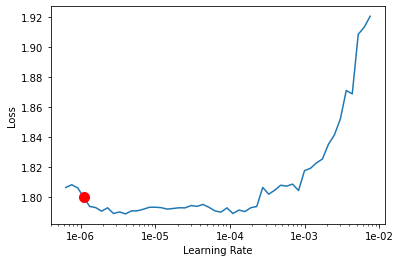

In [34]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.785770,1.771890,0.202346,0.797654,00:18
1,1.777209,1.767872,0.201369,0.798631,00:17


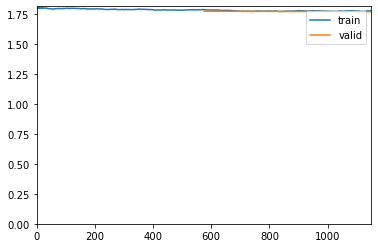

In [35]:
learner.fit_one_cycle(2,1.10E-06,moms=(0.8,0.7))

In [36]:
learner.save('first_cycle')

In [37]:
seed_all(seed)
learner.load('first_cycle');

In [38]:
learner.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 2.51E-06


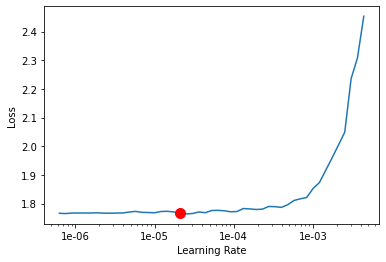

In [39]:
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)

In [40]:
lr = 3E-05

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.726409,1.706788,0.256109,0.743891,00:20


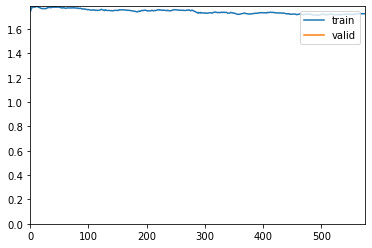

In [41]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [42]:
learner.save('second_cycle')

In [43]:
seed_all(seed)
learner.load('second_cycle');

In [44]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.694062,1.690368,0.254154,0.745846,00:22


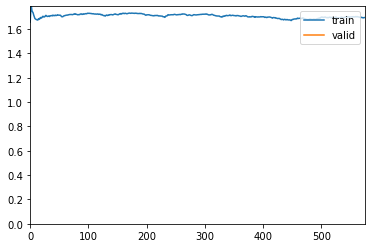

In [45]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [46]:
learner.save('third_cycle')

In [47]:
seed_all(seed)
learner.load('third_cycle');

In [48]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.676122,1.672161,0.279570,0.720430,00:56


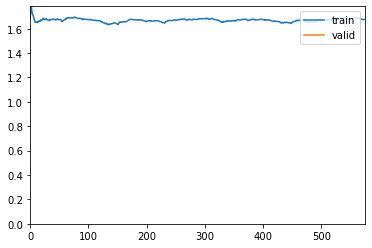

In [49]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [50]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [51]:
test_preds[0][0]

0.20171092

In [52]:
sub = pd.read_csv('../input/mh-20-fakenews/Participants_Data_WH20/sample submission.csv')

In [53]:
sub.head(5)

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
for i in range(0,len(sub)):
    for j in range(0,6):
        sub.iloc[i,j] = test_preds[i][j]

In [55]:
sub.describe()

,0,1,2,3,4,5
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,0.148097,0.165343,0.235676,0.216950,0.055687,0.178249
std,0.059333,0.067998,0.055963,0.076056,0.054022,0.079338
min,0.033923,0.040243,0.071848,0.014927,0.002580,0.005969
25%,0.103805,0.114366,0.198205,0.161599,0.019678,0.117852
50%,0.144837,0.155475,0.226422,0.210871,0.039923,0.172606
75%,0.184257,0.208244,0.262318,0.274702,0.075427,0.236196
max,0.435589,0.483786,0.474071,0.442819,0.491675,0.448781


In [56]:
sub.to_csv('MH20_FastAI_v2d.csv', index = False)# add part 3 1epoch - lb: 1.6831326571397953 - best one